#  Income Prediction Model

The Income Prediction Model is designed to forecast the upcoming month’s total income for a given user based on historical transaction data. The model analyzes monthly income trends, identifies seasonal or recurring patterns, and estimates the expected inflow for the next period. It uses a time series–based Linear Regression model trained on aggregated income data, leveraging past months’ earnings as lagged predictors.
We collect transactions from multiple integrated data sources-including direct personal investigation, controlled experimentation (seeded/synthetic data), user-entered records, and secondary sources such as Plaid Sandbox/API. All transactions (income and expenses) are consolidated in PostgreSQL in the finance_transactions table. For the income prediction model, we filter to confirmed income rows using isIncome = TRUE. This yields only positive inflows (e.g., wages, deposits, refunds) for a given user. Data is pulled with psycopg2 and pandas.read_sql, then handed to the model pipeline.


In [6]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Matplotlib basics
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

# Notebook display
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", 120)

USE_POSTGRES = True  # set False to use CSV fallback



In [7]:

# --- Postgres config (edit as needed) ---
PG_CFG = {
    "dbname":   os.getenv("PGDATABASE", "financeai"),
    "user":     os.getenv("PGUSER", "arjun"),
    "password": os.getenv("PGPASSWORD", "arjun1234"),
    "host":     os.getenv("PGHOST", "localhost"),
    "port":     int(os.getenv("PGPORT", "5432")),
}
USER_ID = 7

SQL_INCOME = """
SELECT
  COALESCE(t.amount, 0)           AS amount,
  t."transactionDate"             AS transaction_date
FROM finance_transactions t
WHERE t."isIncome" = TRUE
  AND t.user_id = %(user_id)s
ORDER BY t."transactionDate";
"""

CSV_PATH = "income_transactions.csv"  # fallback file if not using Postgres

def load_income_df():
    if USE_POSTGRES:
        import psycopg2
        with psycopg2.connect(**PG_CFG) as conn:
            df = pd.read_sql(SQL_INCOME, conn, params={"user_id": USER_ID})
    else:
        # Expecting columns: transaction_date, amount
        df = pd.read_csv(CSV_PATH)
    # Normalize timestamps for monthly grouping
    df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce", utc=True).dt.tz_convert(None)
    df["amount"] = pd.to_numeric(df["amount"], errors="coerce").fillna(0.0)
    df = df.dropna(subset=["transaction_date"]).sort_values("transaction_date")
    return df

df_raw = load_income_df()
df_raw.head()


/var/folders/0w/ylpyfvqd6hj8rwzzyt_d57yh0000gn/T/ipykernel_8336/568117446.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(SQL_INCOME, conn, params={"user_id": USER_ID})


,amount,transaction_date
0,4578.0,2022-11-01 19:00:00
1,454.0,2022-11-08 03:00:00
2,4433.0,2022-12-02 03:00:00
3,397.0,2022-12-23 18:00:00
4,4675.0,2023-01-03 02:00:00


In [4]:
# Monthly Aggregation & Rolling Stats
# Aggregate to month-level income
monthly = (
    df_raw
    .groupby(df_raw["transaction_date"].dt.to_period("M"))["amount"]
    .sum()
    .to_timestamp()
    .rename("income")
    .to_frame()
)

# Rolling statistics (helps visualize trend and smooth noise)
monthly["roll_mean_3"] = monthly["income"].rolling(window=3, min_periods=1).mean()
monthly["roll_mean_6"] = monthly["income"].rolling(window=6, min_periods=1).mean()

# Spike detection via robust Z-score on residuals vs 3-month mean
resid = monthly["income"] - monthly["roll_mean_3"]
mad = np.median(np.abs(resid - np.median(resid))) or 1.0  # avoid divide-by-zero
robust_z = 0.6745 * (resid - np.median(resid)) / mad
monthly["is_spike"] = robust_z > 3  # tune threshold if needed

monthly.tail(12)


,income,roll_mean_3,roll_mean_6,is_spike
transaction_date,,,,
2024-11-01,4737.78,4735.113333,4810.113333,False
2024-12-01,4953.78,4814.780000,4829.280000,False
2025-01-01,5005.78,4899.113333,4819.613333,False
2025-02-01,4746.78,4902.113333,4818.613333,False
2025-03-01,4844.78,4865.780000,4840.280000,False
2025-04-01,4942.78,4844.780000,4871.946667,False
2025-05-01,4878.78,4888.780000,4895.446667,False
2025-06-01,4743.78,4855.113333,4860.446667,False
2025-07-01,4925.78,4849.446667,4847.113333,False


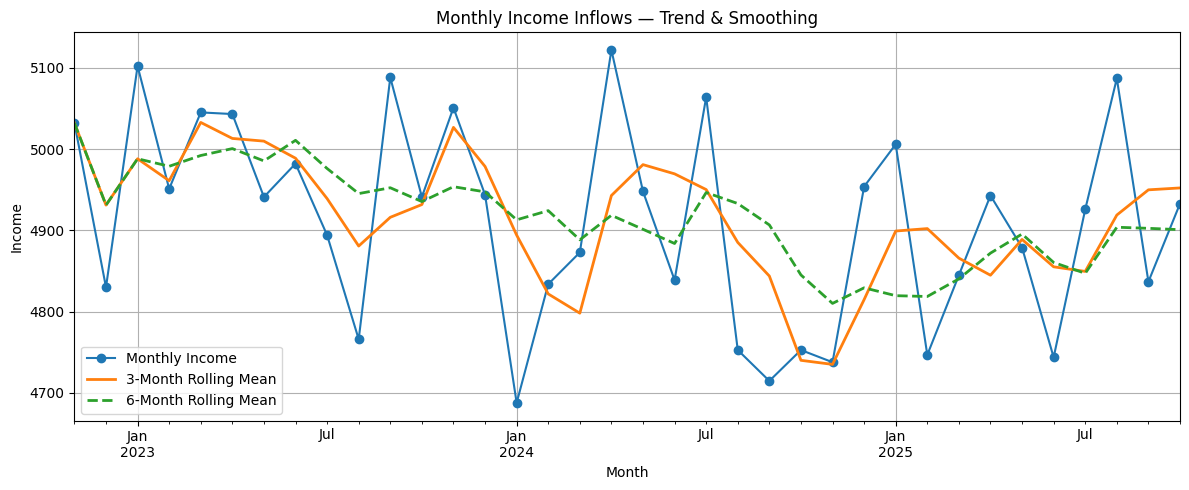

In [8]:
#Time Plot: Monthly Inflows + Rolling Means
ax = monthly["income"].plot(marker="o", linewidth=1.5, label="Monthly Income")
monthly["roll_mean_3"].plot(ax=ax, linewidth=2, label="3-Month Rolling Mean")
monthly["roll_mean_6"].plot(ax=ax, linewidth=2, linestyle="--", label="6-Month Rolling Mean")

plt.title("Monthly Income Inflows — Trend & Smoothing")
plt.xlabel("Month")
plt.ylabel("Income")
plt.legend()
plt.tight_layout()
plt.show()


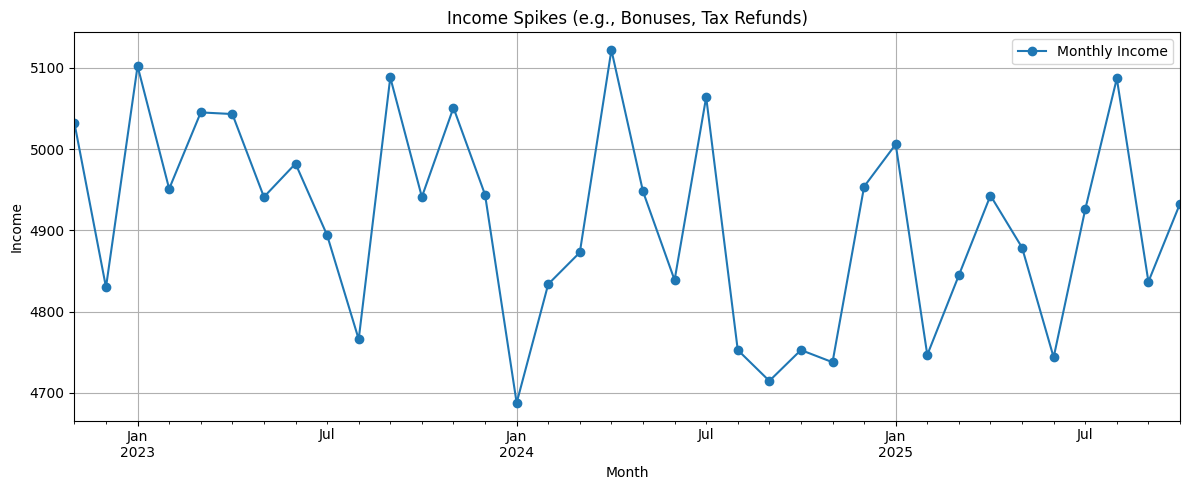

,spike_value
transaction_date,


In [9]:
spikes = monthly[monthly["is_spike"]]
ax = monthly["income"].plot(marker="o", linewidth=1.5, label="Monthly Income")

# Annotate spikes
for idx, row in spikes.iterrows():
    ax.scatter(idx, row["income"], s=80)
    ax.annotate(
        "Spike",
        xy=(idx, row["income"]),
        xytext=(0, 10),
        textcoords="offset points",
        ha="center",
        rotation=0
    )

plt.title("Income Spikes (e.g., Bonuses, Tax Refunds)")
plt.xlabel("Month")
plt.ylabel("Income")
plt.legend()
plt.tight_layout()
plt.show()

spikes[["income"]].rename(columns={"income": "spike_value"})


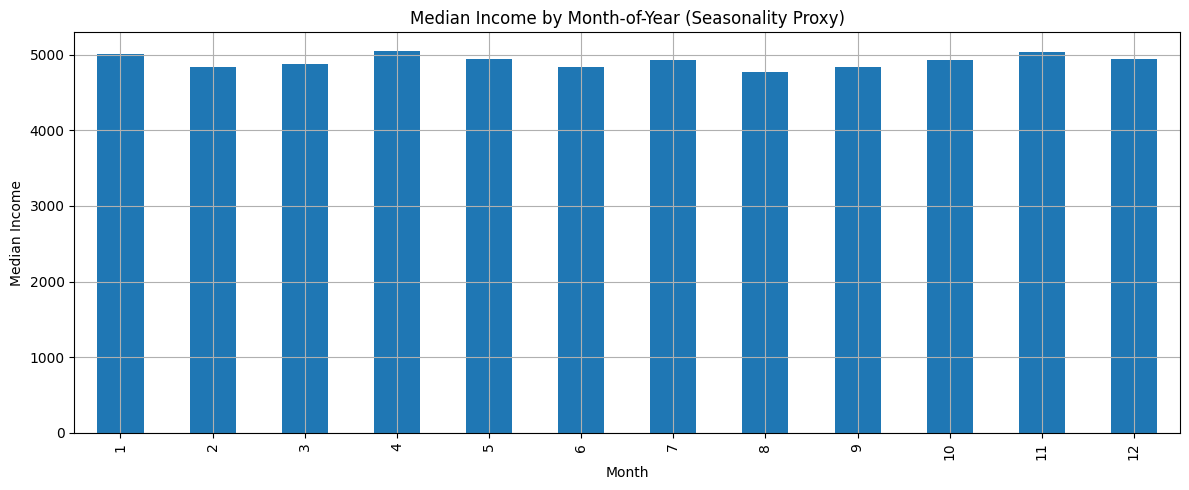

month
1     5005.78
2     4833.78
3     4872.78
4     5043.00
5     4941.00
6     4838.78
7     4925.78
8     4766.00
9     4836.78
10    4932.78
11    5032.00
12    4943.78
Name: income, dtype: float64

In [12]:
season = (
    monthly
    .assign(month=lambda d: d.index.month)
    .groupby("month")["income"]
    .median()
)

ax = season.plot(kind="bar")
plt.title("Median Income by Month-of-Year (Seasonality Proxy)")
plt.xlabel("Month")
plt.ylabel("Median Income")
plt.tight_layout()
plt.show()

season


In [13]:
def money(x):
    return f"${x:,.0f}"

last_12 = monthly.tail(12)["income"]
summary = {
    "Months available": len(monthly),
    "Mean (last 12)": money(last_12.mean()) if len(last_12) else "n/a",
    "Median (last 12)": money(last_12.median()) if len(last_12) else "n/a",
    "Max spike": money(monthly["income"].max()) if len(monthly) else "n/a",
    "Spike months detected": list(spikes.index.strftime("%Y-%m")) if len(spikes) else [],
}
summary


{'Months available': 36,
 'Mean (last 12)': '$4,886',
 'Median (last 12)': '$4,902',
 'Max spike': '$5,122',
 'Spike months detected': []}